In [1]:
import os, yaml
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from tqdm import tqdm
from src.data_utils import *
from torch.utils.data import DataLoader
from src.denoising_utils import *
from src.unet_model import Unet3D
from src.residuals_nematic import ResidualsNematic

In [2]:
os.getcwd()
# os.chdir('./PIDM-Nematics')

'd:\\diffusion model\\TEST4\\denoising-diffusion-flax-20250107T081638Z-001\\PIDM-Nematics-V3-inclusion'

In [3]:
name = 'run_cond_inclusion'
wandb_track = False # set to True to track training with wandb

load_model_flag = False # set to True to load a model
if load_model_flag:
    name = 'your_pretrained_model'
    load_path = './trained_models/' + name
    load_model_step = 0
    config = yaml.safe_load(Path(load_path, 'model', 'model.yaml').read_text())
else:
    config = yaml.safe_load(Path('model.yaml').read_text())

# diffusion parameters
if config['x0_estimation'] == 'mean':
    use_ddim_x0 = False
elif config['x0_estimation'] == 'sample':
    use_ddim_x0 = True
ddim_steps = config['ddim_steps']
residual_grad_guidance = config['residual_grad_guidance'] # gradient guidance scale as in https://www.sciencedirect.com/science/article/pii/S0021999123000670
# residual corrections (can be changed after training since only affects inference) similar to https://arxiv.org/abs/2312.10527
gov_eqs = config['gov_eqs']
fd_acc = config['fd_acc'] # finite difference accuracy
c_data = config['c_data']
c_residual = config['c_residual']
diff_steps = config['diff_steps']
use_dynamic_threshold = False
self_condition = False

# evaluation params
sample_freq = 500
ema_start = 1000
ema = EMA(0.99)
use_double = False
no_samples = 2
save_output = True
eval_residuals = True
create_gif = False

# training parameters and datasets
data_paths = None
if gov_eqs == 'Nematic':
    # [xi_1,xi_2] -> [p,K]
    input_dim = 2
    output_dim = 2
    pixels_at_boundary = True
    domain_length = 1.
    reverse_d1 = False # this is to be consistent with ascending coordinates in the figures
    data_paths = ('./data/Nematic/train/test/Qxx_data_inclusion.csv', './data/Nematic/train/test/Qxy_data_inclusion.csv')
    label_paths = ('./data/Nematic/train/test/Mask1_data_inclusion.csv', './data/Nematic/train/test/Mask_inclusion.csv')
    # data_paths_valid = ('./Nematic/Nematic/valid/Qxx_data.csv', './data/Nematic/valid/Qxy_data.csv')
    bcs = 'none' # 'none', 'periodic'
    pixels_per_dim = 64

    ds = Dataset(data_paths, label_paths, use_double=use_double, return_img=True)
    # ds_valid = Dataset(data_paths_valid, use_double=use_double)
    if use_ddim_x0:
        train_batch_size = 16
    else:
        train_batch_size = 32
    sigmoid_last_channel = False
    train_iterations = 5000
else:
    raise ValueError('Unknown governing equations.')


if use_double:
    torch.set_default_dtype(torch.float64)

dl = cycle(DataLoader(ds, batch_size = train_batch_size, shuffle=True))
# dl_valid = cycle(DataLoader(ds_valid, batch_size = train_batch_size, shuffle=False))


Data shape: (780, 4096, 2)
Label shape: (780, 4096, 2)
Data shape after rearranging: torch.Size([780, 2, 64, 64])
Label shape after rearranging: torch.Size([780, 2, 64, 64])


In [4]:
print('dimension of ds', ds.data.shape)
print('dimension of ds', ds.label.shape)
data_batch, label_batch  = next(dl)
print('dimension of data_batch', data_batch.size())
print('dimension of label_batch', label_batch.size())


dimension of ds torch.Size([780, 2, 64, 64])
dimension of ds torch.Size([780, 2, 64, 64])
dimension of data_batch torch.Size([32, 2, 64, 64])
dimension of label_batch torch.Size([32, 2, 64, 64])


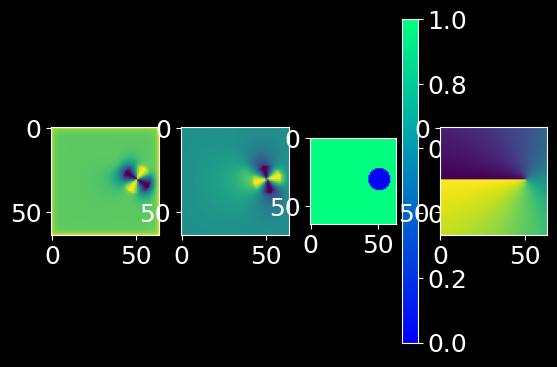

In [5]:
#check if the label is correct
a = 6
data_test1 = data_batch[a,0,:,:].cpu().numpy()
data_test2 = data_batch[a,1,:,:].cpu().numpy()
mask_test1 = label_batch[a,1,:,:].cpu().numpy()
mask_test2 = label_batch[a,0,:,:].cpu().numpy()
plt.subplot(1,4,1)
plt.imshow(data_test1)
plt.subplot(1,4,2)
plt.imshow(data_test2)
plt.subplot(1,4,3)
plt.imshow(mask_test1, cmap='winter')
plt.colorbar()
plt.subplot(1,4,4)
plt.imshow(mask_test2)


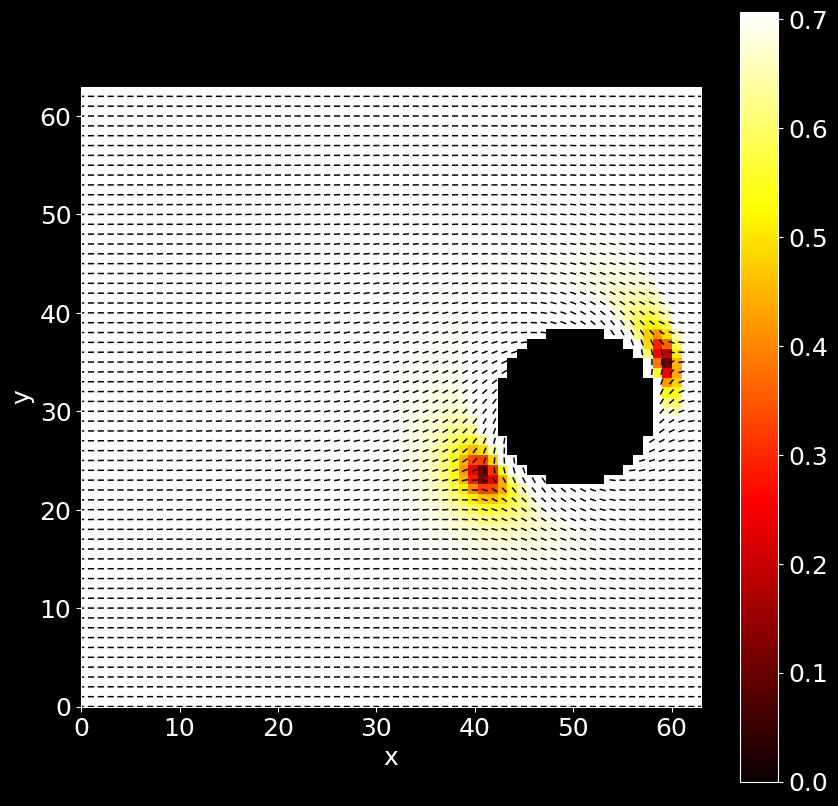

In [6]:
N1=64
N2=64
Qxx = data_test1
Qxy = data_test2
nx = np.zeros((N2,N1))
ny = np.zeros((N2,N1))
S = np.zeros((N2,N1))
x, y = np.meshgrid(np.arange(0, N1, 1), np.arange(0, N2, 1))
for i in range(N2):
    for j in range(N1):
        matrix = np.array([[Qxx[i, j], Qxy[i, j]],
                        [Qxy[i, j], -Qxx[i, j]]])
        vals, vecs = np.linalg.eigh(matrix)
        index = np.argmax(vals)
        nx[i,j] = vecs[0, index]
        ny[i,j] = vecs[1, index]
        S[i,j] = vals[index]*2


S[mask_test1==0] = np.nan
nx[mask_test1==0] = np.nan
ny[mask_test1==0] = np.nan
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(S, cmap='hot', interpolation='nearest', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], vmin=0, vmax=0.707)
plt.colorbar(im)
plt.xlabel('x')
plt.ylabel('y')
ax.quiver(x, y, nx, ny, color='black', scale=100, headlength=0, headaxislength=0, headwidth=0, pivot='middle')

In [7]:

# diffusion utils
diffusion_utils = DenoisingDiffusion(diff_steps, device, residual_grad_guidance)
# model 
if gov_eqs == 'Nematic':
    model = Unet3D(dim = 32, channels = output_dim, sigmoid_last_channel = sigmoid_last_channel).to(device)
else:
    raise ValueError('Unknown governing equations, cannot create model.')
if load_model_flag:
    load_model(Path(load_path, 'model', 'checkpoint_' + str(load_model_step) + '.pt'), model)
ema.register(model)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {num_params}')

# residual computation based on governing equations
if gov_eqs == 'Nematic':
    residuals = ResidualsNematic(model = model, fd_acc = fd_acc, pixels_per_dim = pixels_per_dim, pixels_at_boundary = pixels_at_boundary, reverse_d1 = reverse_d1, device = device, bcs = bcs, domain_length = domain_length, residual_grad_guidance= residual_grad_guidance, use_ddim_x0 = use_ddim_x0, ddim_steps = ddim_steps)
else:
    raise ValueError('Unknown residuals mode.')

optimizer = optim.AdamW(model.parameters(), lr=1.e-3, weight_decay=0.01)

# optimizer = optim.Adam(model.parameters(), lr=1.e-4)

if wandb_track:
    import wandb
    wandb.init(project='PIDM_Nematic', name=name)
    log_fn = wandb.log
else:
    log_fn = noop
log_freq = 20
clip_counter = 0
clip_freq = 100
def get_grad_norm(parameters):
    gradients = [p.grad for p in parameters if p.grad is not None]
    if not gradients:
        return 0.0
    total_norm = torch.norm(torch.stack([torch.norm(g.detach(), 2) for g in gradients]), 2)
    return total_norm.item()

Number of trainable parameters: 10386482


In [8]:

    
output_save_dir = f'./trained_models/{name}'
os.makedirs(output_save_dir, exist_ok=True)
loss_csv = []
data_loss_csv = []
residual_loss_csv = []
pbar = tqdm(range(train_iterations+1))
for iteration in pbar:
    model.train()
    data_batch, label_batch = next(dl)
    data_batch = data_batch.to(device)
    label_batch = label_batch.to(device)
    loss, data_loss, residual_loss = diffusion_utils.model_estimation_loss(
                data_batch, label_batch, residual_func = residuals, c_data = c_data, c_residual = c_residual)    
    optimizer.zero_grad()
    loss.backward()
    total_grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
    # if total_grad_norm > 2.0:
    #     clip_counter += 1
    #     total_grad_norm2 = get_grad_norm(model.parameters())
    #     # print(f'Iteration {iteration}: Gradient norm is too large: {total_grad_norm:.2f}')
    #     # print(f'Iteration {iteration}: Gradient norm is too large: {total_grad_norm2:.2f}')
    optimizer.step()    
    # logging
    if iteration % log_freq == 0:
        loss_csv.append(loss.item())
        data_loss_csv.append(data_loss)
        residual_loss_csv.append(residual_loss)
        pbar.set_description(f'training loss: {loss.item():.3e}')
        pbar.set_postfix({'loss': loss.item(), 'data_loss': data_loss, 'residual_loss': residual_loss})
        log_fn({'loss': loss.item()}, step=iteration)
        log_fn({'loss_data': data_loss}, step=iteration)
        log_fn({'residual_mean_abs': residual_loss}, step=iteration)
    # ema update
    if iteration > ema_start:
        ema.update(model)

    # evaluation on validation set
    model.eval()
    ema.ema(residuals.model)

    # generate and evaluate samples
    if (iteration % sample_freq == 0) or (iteration == train_iterations):        
        if gov_eqs == 'Nematic':
            conditioning_input = None
            sample_shape = (no_samples, output_dim, pixels_per_dim, pixels_per_dim)
        N1 = 64
        N2 = 64
        # make this as for loop
        icx_list = []
        icy_list = []
        R_list = []
        anchoring_type_list = []
        inclusion_list = []
        anchoring_direction_list = []
        Mask_input = torch.zeros((no_samples, 2, N1, N2))
        for i in range(no_samples):
            icx = N1/2 + np.random.randint(-10, 10)
            icy = N2/2 + np.random.randint(-10, 10)
            R = np.random.randint(8, 12)
            anchoring_type = np.random.randint(1, 5)
            # inclusion = np.random.choice([True, False])
            inclusion = True
            anchoring_direction = 2*np.pi*np.random.rand()
            mask = diffusion_utils.generate_mask(N1, N2, icx, icy, R, anchoring_type, inclusion, anchoring_direction)
            icx_list.append(icx)
            icy_list.append(icy)
            R_list.append(R)
            anchoring_type_list.append(anchoring_type)
            inclusion_list.append(inclusion)
            anchoring_direction_list.append(anchoring_direction)
            Mask_input[i] = torch.tensor(mask)  # 显式指定设备
        
        output = diffusion_utils.p_sample_loop(conditioning_input, Mask_input, sample_shape, 
                                save_output=save_output, surpress_noise=True, 
                                use_dynamic_threshold=use_dynamic_threshold, 
                                residual_func=residuals, eval_residuals = eval_residuals)
        
        if eval_residuals:
            seqs = output[0]
            residual = output[1]['residual']
            residual = residual.abs().mean(dim=tuple(range(1, residual.ndim))) # reduce to batch dim
        else:
            seqs = output
            
        output_save_dir_step = output_save_dir + f'/training/step_{iteration}/'
        os.makedirs(output_save_dir_step, exist_ok=True)
                
        labels = ['sample', 'model_output']
        for seq_idx, seq in enumerate(seqs):

            # NOTE: We here only evaluate the sample at the final timestep and skip model_output as this is identical (since no noise is applied in last step).
            if seq_idx == 1:
                continue

            seq = torch.stack(seq, dim=0)

            if len(seq.shape) == 6:
                seq = seq.squeeze(-3)
                
            last_preds = seq[-1].numpy()
            sel_samples = np.arange(len(last_preds))
            channels = np.arange(output_dim)

            for sel_sample in sel_samples:
                last_pred = last_preds[sel_sample, :]
                last_pred_temp = rearrange(last_pred, 'c h w -> h w c')
                Qxx = last_pred_temp[:,:,0]
                Qxy = last_pred_temp[:,:,1]
                N2, N1 = Qxx.shape
                nx = np.zeros((N2,N1))
                ny = np.zeros((N2,N1))
                S = np.zeros((N2,N1))
                Azi = Mask_input[sel_sample,0,:,:]
                Seq = np.sqrt(2)/2
                Azi_Qxx = Seq * np.cos(2*Azi)
                Azi_Qxy = Seq * np.sin(2*Azi)
                Qxx = np.where(Mask_input[sel_sample,1,:,:] == 0, Azi_Qxx, Qxx)
                Qxy = np.where(Mask_input[sel_sample,1,:,:] == 0, Azi_Qxy, Qxy)
                x, y = np.meshgrid(np.arange(0, N1, 1), np.arange(0, N2, 1))
                for i in range(N2):
                    for j in range(N1):
                        matrix = np.array([[Qxx[i, j], Qxy[i, j]],
                                        [Qxy[i, j], -Qxx[i, j]]])
                        vals, vecs = np.linalg.eigh(matrix)
                        index = np.argmax(vals)
                        nx[i,j] = vecs[0, index]
                        ny[i,j] = vecs[1, index]
                        S[i,j] = vals[index]*2
                # plt.figure(figsize=(10, 10))
                # S[Mask_input[sel_sample,1,:,:] == 0] = np.nan
                # nx[Mask_input[sel_sample,1,:,:] == 0] = np.nan
                # ny[Mask_input[sel_sample,1,:,:] == 0] = np.nan
                S = np.where(Mask_input[sel_sample,1,:,:] != 0, S, np.nan)
                nx = np.where(Mask_input[sel_sample,1,:,:] != 0, nx, np.nan)
                ny = np.where(Mask_input[sel_sample,1,:,:] != 0, ny, np.nan)
                fig, ax = plt.subplots(figsize=(10, 10))
                im = ax.imshow(S, cmap='hot', interpolation='nearest', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], vmin=0, vmax=0.707)
                plt.colorbar(im)
                plt.xlabel('x')
                plt.ylabel('y')
                ax.quiver(x, y, nx, ny, color='black', scale=100, headlength=0, headaxislength=0, headwidth=0, pivot='middle')
                # add a circle
                if eval_residuals:
                    title = f'eq: {residual[sel_sample]:.2e}, \n icx, icy R type inclusion= {icx_list[sel_sample], icy_list[sel_sample],R_list[sel_sample], anchoring_type_list[sel_sample], inclusion_list[sel_sample]} '
                    plt.title(title, color='green')
                filename = labels[seq_idx] + '_Qtensor_' + str(sel_sample)  + '.png'
                plt.savefig(output_save_dir_step + filename, bbox_inches='tight', pad_inches=0)
                plt.close(fig)

                os.makedirs(output_save_dir_step + f'/sample_{sel_sample}/', exist_ok=True)
                for sel_channel in channels:
                    np.savetxt(output_save_dir_step + f'/sample_{sel_sample}/' + labels[seq_idx] + '_' + str(sel_channel) + '.csv', last_pred[sel_channel], delimiter=',')

                    if create_gif:
                        sel_seq = seq[:, sel_sample, sel_channel].detach().cpu().numpy()
                        image_array_to_gif(sel_seq, output_save_dir_step + f'/sample_{sel_sample}/' + labels[seq_idx] + '_' + str(sel_channel) + '.gif')


        if eval_residuals:
            residuals_array = residual.detach().cpu().numpy()
            # logging
            log_fn({'residual_mean_abs_samples': np.nanmean(residuals_array)}, step=iteration)
            log_fn({'residual_median_abs_samples': np.nanmedian(residuals_array)}, step=iteration)
            df_data = {'Sample Index': list(range(no_samples)),
                    'Residuals (abs)': list(residuals_array)}
            print(df_data)
            df = pd.DataFrame(df_data)
            csv_path = os.path.join(output_save_dir_step, 'sample_statistics.csv')
            df.to_csv(csv_path, index=False)

        
        if iteration > 0:
            save_model(config, model, iteration, output_save_dir)
            # save loss_csv to output directory



    ema.restore(residuals.model)

df_data = {'Iteration': list(range(0, iteration+1, log_freq)),
        'Loss': loss_csv,
        'Data Loss': data_loss_csv,
        'Residual Loss': residual_loss_csv}
df = pd.DataFrame(df_data)
csv_path = os.path.join(output_save_dir, 'loss.csv')
df.to_csv(csv_path, index=False)

if wandb_track:
    wandb.finish()

training loss: 1.230e+05:   0%|          | 1/5001 [00:26<36:45:09, 26.46s/it, loss=1.23e+5, data_loss=0.772, residual_loss=1.23e+5]

{'Sample Index': [0, 1], 'Residuals (abs)': [7.61833, 8.490611]}


training loss: 1.114e-01:  10%|█         | 501/5001 [03:30<9:30:23,  7.61s/it, loss=0.111, data_loss=0.00779, residual_loss=0.104] 

{'Sample Index': [0, 1], 'Residuals (abs)': [8.570801, 8.623656]}

checkpoint saved to ./trained_models/run_cond_inclusion/.


training loss: 2.566e-01:  20%|██        | 1001/5001 [06:38<8:12:52,  7.39s/it, loss=0.257, data_loss=0.00993, residual_loss=0.247]

{'Sample Index': [0, 1], 'Residuals (abs)': [7.4207354, 10.518101]}

checkpoint saved to ./trained_models/run_cond_inclusion/.


training loss: 1.013e-01:  30%|███       | 1501/5001 [09:50<7:11:39,  7.40s/it, loss=0.101, data_loss=0.00652, residual_loss=0.0948]

{'Sample Index': [0, 1], 'Residuals (abs)': [0.044981588, 0.04532581]}

checkpoint saved to ./trained_models/run_cond_inclusion/.


training loss: 1.847e-01:  40%|████      | 2001/5001 [13:01<6:02:30,  7.25s/it, loss=0.185, data_loss=0.00876, residual_loss=0.176] 

{'Sample Index': [0, 1], 'Residuals (abs)': [0.045242384, 0.044875965]}

checkpoint saved to ./trained_models/run_cond_inclusion/.


training loss: 1.849e-01:  50%|█████     | 2501/5001 [16:10<4:57:36,  7.14s/it, loss=0.185, data_loss=0.00711, residual_loss=0.178]

{'Sample Index': [0, 1], 'Residuals (abs)': [0.04600004, 0.04564003]}

checkpoint saved to ./trained_models/run_cond_inclusion/.


training loss: 1.428e-01:  60%|██████    | 3001/5001 [19:22<4:05:53,  7.38s/it, loss=0.143, data_loss=0.00682, residual_loss=0.136]

{'Sample Index': [0, 1], 'Residuals (abs)': [0.0453362, 0.044991836]}

checkpoint saved to ./trained_models/run_cond_inclusion/.


training loss: 2.588e-01:  70%|███████   | 3501/5001 [22:34<3:03:21,  7.33s/it, loss=0.259, data_loss=0.00736, residual_loss=0.251]

{'Sample Index': [0, 1], 'Residuals (abs)': [0.04716993, 0.045601733]}

checkpoint saved to ./trained_models/run_cond_inclusion/.


training loss: 2.280e-01:  80%|████████  | 4001/5001 [25:44<2:01:09,  7.27s/it, loss=0.228, data_loss=0.00944, residual_loss=0.219]

{'Sample Index': [0, 1], 'Residuals (abs)': [0.045285545, 0.04682204]}

checkpoint saved to ./trained_models/run_cond_inclusion/.


training loss: 1.512e-01:  90%|█████████ | 4501/5001 [28:54<1:02:04,  7.45s/it, loss=0.151, data_loss=0.00522, residual_loss=0.146]

{'Sample Index': [0, 1], 'Residuals (abs)': [0.046196386, 0.046205748]}

checkpoint saved to ./trained_models/run_cond_inclusion/.


training loss: 1.154e-01: 100%|██████████| 5001/5001 [32:05<00:00,  2.60it/s, loss=0.115, data_loss=0.00521, residual_loss=0.11]   

{'Sample Index': [0, 1], 'Residuals (abs)': [0.045388326, 0.04728555]}

checkpoint saved to ./trained_models/run_cond_inclusion/.
